# Data import testing and bot building 

- Bots will be a class
- Each bot manages a portfolio 
- Bots talk 
- Bots share resources
- Sharing of resources is balanced globally
- Buy and sell decisions are local to bots 
- Couplings between bots are based on informational coupling of stocks (Transfer Entropy)

Questions: 
- What time frame is the transfer entropy pulling from?
- TransEnt over multiple days to get averages, weight by temporal distance from now. 


To Do 
- [x ] Import data 
- [x ] Transfer entropy between stocks, see if this makes graph (IT DOES)
- [ ] Build proto-bot class
- [ ] Build portofolio 
- [ ] Bot manage with portfolio


In [105]:
import yfinance as yf
import os
import pandas as pd
import pyinform  # For transfer entropy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import matplotlib.cm as cm 
from matplotlib.colors import Normalize

In [106]:
# Function to fetch and update stock data
# Period must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
def fetch_and_save_stock_data(ticker,csv_tf, period='1d', interval='1m'):
    stock = yf.Ticker(ticker)
    
    try:
        # Fetch the historical stock data
        data = stock.history(period=period, interval=interval)
        #Check if data is empty
        if data.empty:
            print(f"${ticker}: no price data found (Yahoo error = 'No data found, symbol may be delisted')")
            return
        # Ensure the Datetime index is in proper format
        if not isinstance(data.index, pd.DatetimeIndex):
            data.index = pd.to_datetime(data.index)
            
            
        # data = data[data.High!=data.Low] # Should get rid of breaks in trading (Doesn't lol) Gonna do it by date
        
        if csv_tf == True:
            # Save the data in a CSV file
            filename = f"data/{ticker}_historical_data.csv"
            data.to_csv(filename, index=True)
            
            print(f"Data for {ticker} saved to {filename}")
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
    return data

''' 
CRUCIAL TO NOTE
1400GMT is 0900EST. Market Opens at 0900EST. 
There needs to be a way to adjoing data really, right now:
THIS PULLS FOR THE CURRENT DAY 
'''

# Fetch data for two stocks
stock_1 = "GOOGL"  # Apple
stock_2 = "NFLX"  # Google

# Fetch and save stock data for both
data_1 = fetch_and_save_stock_data(stock_1,True)
data_2 = fetch_and_save_stock_data(stock_2,True)

Data for GOOGL saved to data/GOOGL_historical_data.csv
Data for NFLX saved to data/NFLX_historical_data.csv


In [107]:
# Ensure both datasets have the same 'Datetime' index
def align_datasets(data_1, data_2):
    # Align the datasets by merging on the Datetime index (intersection)
    merged_data = pd.merge(data_1[['Close']], data_2[['Close']], left_index=True, right_index=True, suffixes=('_1', '_2'))
    
    # Drop any rows with NaN values
    merged_data = merged_data.dropna()
    
    return merged_data

# Align the stock data for transfer entropy calculation
aligned_data = align_datasets(data_1, data_2)
print(aligned_data.head())  # Inspect the first few rows

                              Close_1     Close_2
Datetime                                         
2024-10-22 09:30:00-04:00  163.229996  764.424988
2024-10-22 09:31:00-04:00  164.039993  767.164978
2024-10-22 09:32:00-04:00  164.270004  767.460999
2024-10-22 09:33:00-04:00  164.289993  768.808472
2024-10-22 09:34:00-04:00  164.000000  767.799988


In [108]:
# Calculate transfer entropy using the pyinform library
def calculate_transfer_entropy(source, target, k):
    # Discretize the time series (normalize and bin the data for pyinform)
    bins = 10  # You can adjust the number of bins as needed
      # Print some values for inspection
 
    # Ensure inputs are 1D arrays
    if source.ndim != 1 or target.ndim != 1:
        raise ValueError("Input arrays must be 1-dimensional.")
  
    source_discretized = pd.qcut(source, bins, labels=False, duplicates='drop').values
    target_discretized = pd.qcut(target, bins, labels=False, duplicates='drop').values
    
    # Calculate transfer entropy
    te_value = pyinform.transferentropy.transfer_entropy(source_discretized, target_discretized, k)
    
    return te_value

# Value of timewindow
k = 3


# Extract the close prices from the aligned datasets
close_prices_1 = aligned_data['Close_1']
close_prices_2 = aligned_data['Close_2']

# Calculate transfer entropy in both directions
te_1_to_2 = calculate_transfer_entropy(close_prices_1, close_prices_2,k)
te_2_to_1 = calculate_transfer_entropy(close_prices_2, close_prices_1,k)

print(f"Transfer entropy from {stock_1} to {stock_2}: {te_1_to_2}")
print(f"Transfer entropy from {stock_2} to {stock_1}: {te_2_to_1}")

Transfer entropy from GOOGL to NFLX: 0.175
Transfer entropy from NFLX to GOOGL: 0.3081877754006699


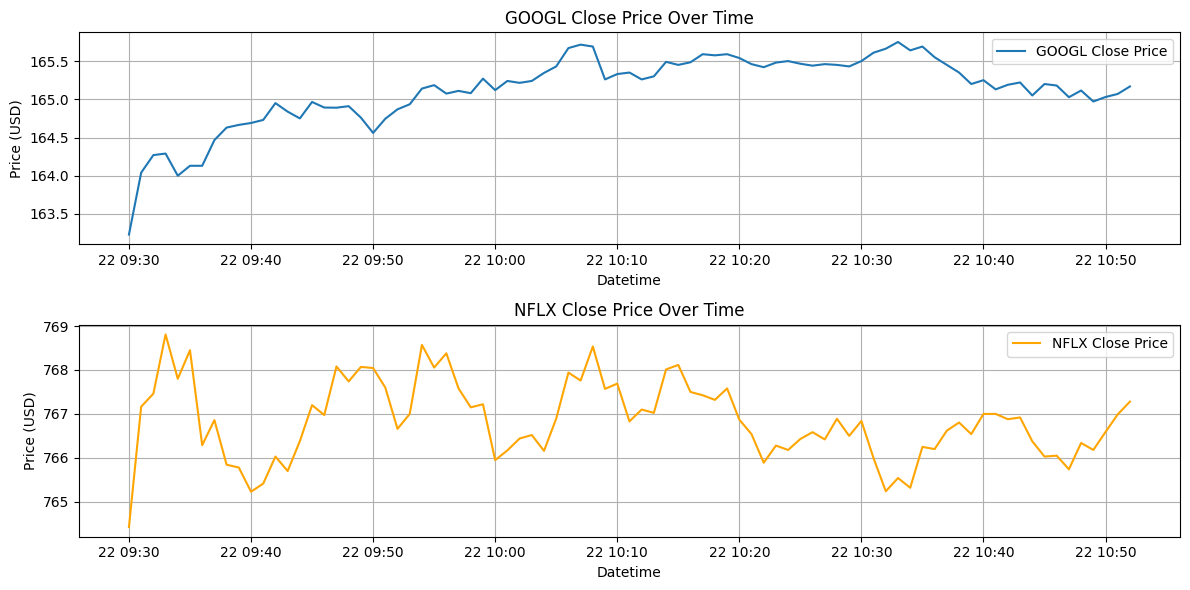

In [109]:
# Plot the stock prices and transfer entropy values
plt.figure(figsize=(12, 6))

# Plot stock 1 close prices
plt.subplot(2, 1, 1)
plt.plot(aligned_data.index, close_prices_1, label=f'{stock_1} Close Price')
plt.title(f'{stock_1} Close Price Over Time')
plt.xlabel('Datetime')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()

# Plot stock 2 close prices
plt.subplot(2, 1, 2)
plt.plot(aligned_data.index, close_prices_2, label=f'{stock_2} Close Price', color='orange')
plt.title(f'{stock_2} Close Price Over Time')
plt.xlabel('Datetime')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [110]:
def create_graph(te_dict):
    G = nx.Graph()
    # Extract transfer entropy values for normalization
    te_values = [te[0] for te in te_dict.values()] + [te[1] for te in te_dict.values()]
    
    # Normalize the transfer entropy values for coloring
    norm = Normalize(vmin=min(te_values), vmax=max(te_values))
    # Generate colors for each TE value
    colors = [cm.viridis(norm(te_ab)) for (stock_a, stock_b), (te_ab, te_ba) in te_dict.items()]

    for i, ((stock_a, stock_b), te_values) in enumerate(te_dict.items()):
        te_ab, te_ba = te_values
        if te_ab > 0:  # Only add edges with positive transfer entropy
            G.add_edge(stock_a, stock_b, weight=te_ab, color=colors[i], te_value=te_ab)
        if te_ba > 0:  # Add reverse direction if needed
            G.add_edge(stock_b, stock_a, weight=te_ba, color=colors[i], te_value=te_ba)
    return G, te_values


Data for AAPL saved to data/AAPL_historical_data.csv
Data for GOOGL saved to data/GOOGL_historical_data.csv
Data for MSFT saved to data/MSFT_historical_data.csv
Data for AMZN saved to data/AMZN_historical_data.csv
Data for TSLA saved to data/TSLA_historical_data.csv
Data for NFLX saved to data/NFLX_historical_data.csv
Data for NVDA saved to data/NVDA_historical_data.csv
Data for INTC saved to data/INTC_historical_data.csv
Data for CSCO saved to data/CSCO_historical_data.csv
Transfer entropy from AAPL to GOOGL: 0.2844360937770434
Transfer entropy from GOOGL to AAPL: 0.15943609377704335
Transfer entropy from AAPL to MSFT: 0.31399269348454684
Transfer entropy from MSFT to AAPL: 0.18443609377704334
Transfer entropy from AAPL to AMZN: 0.33112781244591327
Transfer entropy from AMZN to AAPL: 0.1
Transfer entropy from AAPL to TSLA: 0.125
Transfer entropy from TSLA to AAPL: 0.15
Transfer entropy from AAPL to NFLX: 0.2
Transfer entropy from NFLX to AAPL: 0.2
Transfer entropy from AAPL to NVDA: 0

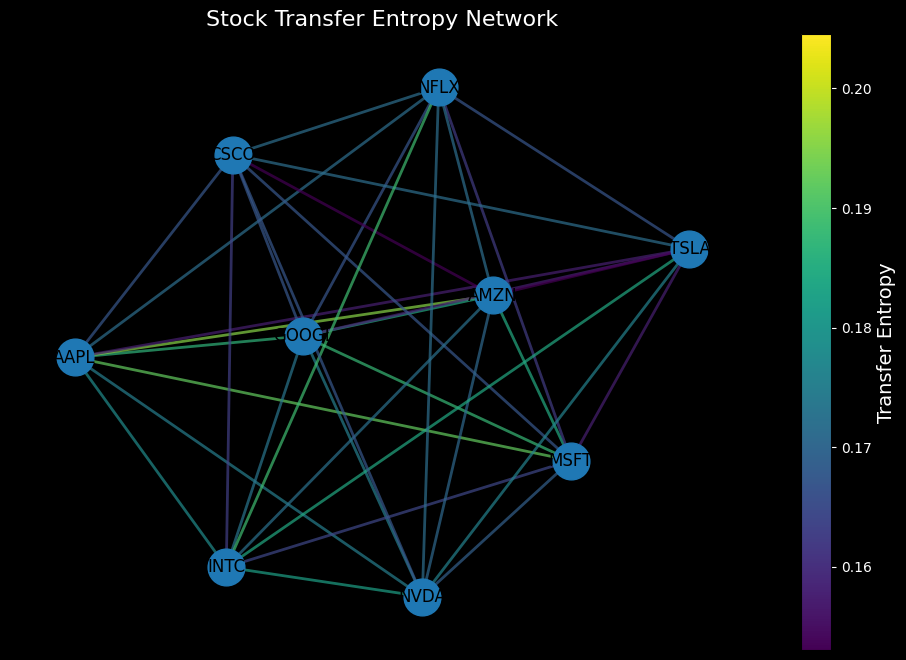

In [111]:
# Fetch data for 10 stocks
# Fetch data for 10 stocks
tickers = ["AAPL", "GOOGL", "MSFT", "AMZN", "TSLA", "NFLX", "NVDA", "INTC", "CSCO"]
number = np.zeros(len(tickers))
portfolio = dict(zip(tickers,number))
data = {}  # Initialize an empty dictionary to store data

for ticker in tickers:
    data[ticker] = fetch_and_save_stock_data(ticker,True)  # Store each ticker's data

# Calculate transfer entropy for each pair of stocks
transfer_entropy_dict = {}
for stock_a, stock_b in combinations(tickers, 2):
    if stock_a in data and stock_b in data:
        
        
        
        # Align the stock data for transfer entropy calculation
        aligned_data = align_datasets(data[stock_a], data[stock_b])   
        # Extract the close prices from the aligned datasets
        close_prices_1 = aligned_data['Close_1']
        close_prices_2 = aligned_data['Close_2']

        # Calculate transfer entropy in both directions
        te_ab = calculate_transfer_entropy(close_prices_1, close_prices_2,k)
        te_ba = calculate_transfer_entropy(close_prices_2, close_prices_1,k)
        
        # te_ab = calculate_transfer_entropy(data[stock_a], data[stock_b],k)
        # te_ba = calculate_transfer_entropy(data[stock_b], data[stock_a],k)
        transfer_entropy_dict[(stock_a, stock_b)] = (te_ab, te_ba)
        print(f"Transfer entropy from {stock_a} to {stock_b}: {te_ab}")
        print(f"Transfer entropy from {stock_b} to {stock_a}: {te_ba}")

''' 
Graph seems a little busted
Transfer ent values seem off based on print outs. 
'''


# Create a graph from the transfer entropy values
graph, te_values = create_graph(transfer_entropy_dict)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(graph)  # Layout for visualizing the graph
edges = graph.edges(data=True)

# Draw nodes
nx.draw_networkx_nodes(graph, pos, node_size=700)

# Draw edges with colors based on transfer entropy
edge_colors = [data['color'] for _, _, data in edges]
nx.draw_networkx_edges(graph, pos, edge_color=edge_colors, width=2, alpha=0.7)

# # Draw labels on edges
# edge_labels = {(stock_a, stock_b): f"{data['te_value']:.2f}" for stock_a, stock_b, data in edges}
# nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='black')

# Draw node labels
nx.draw_networkx_labels(graph, pos, font_size=12)


# # Add color bar for transfer entropy
# sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=Normalize(vmin=min(te_values), vmax=max(te_values)))
# sm.set_array([])  # Only needed for older Matplotlib versions
# # Create a colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=Normalize(vmin=min(te_values), vmax=max(te_values)))
sm.set_array([])  # Only needed for older versions of matplotlib
# Explicitly specify the current axes for the color bar
cbar = plt.colorbar(sm, ax=plt.gca(), label='Transfer Entropy')
cbar.set_label('Transfer Entropy', fontsize=14, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
cbar.ax.yaxis.set_tick_params(labelcolor='white')
# Change the background color of the plot
plt.gca().set_facecolor('black')  # Set background color
plt.gcf().patch.set_facecolor('black')  # Set figure background color

# Set the title and show the plot
plt.title("Stock Transfer Entropy Network", fontsize=16, color='white')
plt.axis('off')  # Hide axes
plt.show()

In [118]:

# Bots
# Manage subsections of the global portfolios
# Buy/Sell decisions are local to a bots portfolio INFORMED by connected information
# Information should be based on potential and be intelligent. Informed by information metrics aswell as market trends
# Eventually bots will have portfolio listeners

# Bot to do;
# [] Functionality to manage a port
# [] Information metrics informed management
# [] What type of FinBro strat will the bot run? scalping?
# Simple strat FIRST, add in complexity when needed
#Bot eccosystem, multiple strats running at once, potency of different interactions would change (FOR LATER ON)


class Bot:
    #Bots have access to a portfolio, the ability to buy sell within a portfolio, and a surplus to spend
    def __init__(self, id, portfolio) -> None:
        self.id = id
        self.pf = portfolio # stocks the bot holds and amounts [dict w/ ticker,amount]
        itt = 0
        self.tickers = []
        self.holds = [] 
        for stock,holds in self.pf.items(): # loop the portfolio
            self.tickers.append(stock)
            self.holds.append(holds)
            itt += 1
        self.data = {}  # Initialize an empty dictionary to store data
        self.real_money = 0 # Money out of stocks
        self.KnowledgeUpdate()
        self.Assess() # Money tied up in stocks
        print(f'Bot {self.id} Intialised')
        print(self.pf)
        print(self.holds)
        print(self.tickers)
        pass
    
    # Updates bots knowledge
    # Knowledge is the bots sense of things including
    ## Stock Data
    ## Information metrics
    ## Other bot status/movement reports
    def KnowledgeUpdate(self):
        
        # Stock Data Update
        for stock in self.tickers: # loop the portfolio
            self.data[stock] = fetch_and_save_stock_data(stock,False)  # Store each ticker's data
            
        # Trans Entropy updates
        # Calculate transfer entropy for each pair of stocks
        transfer_entropy_dict = {}
        
        for stock_a, stock_b in combinations(self.tickers, 2):
            if stock_a in self.data and stock_b in self.data:
                
                # Align the stock data for transfer entropy calculation
                aligned_data = align_datasets(self.data[stock_a], self.data[stock_b])   
                # Extract the close prices from the aligned datasets
                close_prices_1 = aligned_data['Close_1']
                close_prices_2 = aligned_data['Close_2']

                # Calculate transfer entropy in both directions
                te_ab = calculate_transfer_entropy(close_prices_1, close_prices_2,k)
                te_ba = calculate_transfer_entropy(close_prices_2, close_prices_1,k)
                
                # te_ab = calculate_transfer_entropy(data[stock_a], data[stock_b],k)
                # te_ba = calculate_transfer_entropy(data[stock_b], data[stock_a],k)
                transfer_entropy_dict[(stock_a, stock_b)] = (te_ab, te_ba)
        
    
    # Bot assess portfolio value and, eventually, strength of this based on informaton theoretic metrics
    def Assess(self):
        stock_value_1 = np.zeros((len(self.pf),1)) # this iterations stock value
        itt = 0
        for stock,holds in self.pf.items():
            # check the value of stocks at current iteration 
            stock_value_1[itt] = holds*self.data[stock][['Close']].values[0]
            itt += 1
        self.stock_value = np.sum(stock_value_1) # worth zipping this into portfolio? 
        
        
    
    # Bot portfolio is fixed, stocks can take 0 value. 
    def PortUpdate(self): 
        
       pass
        
    def Sell(self):
        pass
    def Buy(self):
        pass 
            

In [121]:
tickers = ["AAPL", "GOOGL", "MSFT", "AMZN", "TSLA", "NFLX", "NVDA", "INTC", "CSCO"]
holding = []
# Test number generator 
for i in range(0,len(tickers)):
    holding.append(i)
    
portfolio = dict(zip(tickers,holding))
Test_Bot = Bot('1',portfolio)
Test_Bot.KnowledgeUpdate()
bot_data = Test_Bot.data



Bot 1 Intialised


In [122]:

Test_Bot.Assess()
print(Test_Bot.stock_value)

7712.148473739624
